In [279]:
library(DALEX)
library(auditor)

# Generating data

In [280]:
true_model <- function(model, data){
    return(abs(500 + 100 * (abs(data$year_of_birth - 1000) > 500) + 
           0.02 * (data$height - 50)^2 + 40 * data$scars + 20 * data$number_of_lost_teeth))
}

In [281]:
N <- 2000
set.seed(756)

year_of_birth <- round(runif(N, -2000, 1800)) # year, for negative -n = n + 1 BC
year_of_discovery <- sort(round(runif(N, 1700, 1800))) # year
height <- rgamma(N, 50) # yards
weight <- 1/4 * height + rexp(N, 1) # tons
scars <- round(rexp(N, 0.1)) # number
number_of_lost_teeth <- round(runif(N, 0, 40)) # number
colour <- sample(c('red', 'blue', 'green', 'black'), N, replace=TRUE, p=c(0.5, 0.3, 0.18, 0.02))
life_length <- true_model(NULL, data.frame(year_of_birth, height, weight, 
                                           scars, colour, year_of_discovery, 
                                           number_of_lost_teeth)) + rnorm(N, 0, 20)
dragons <- data.frame(year_of_birth, height, weight, scars, colour, 
                 year_of_discovery, number_of_lost_teeth, life_length)

In [282]:
N <- 1000
set.seed(1)

year_of_birth <- round(runif(N, -2000, 2000)) # year, for negative -n = n + 1 BC
year_of_discovery <- sort(round(runif(N, 1800, 2000))) # year
colour <- sample(c('red', 'blue', 'green', 'black'), N, replace=TRUE, p=c(0.4, 0.3, 0.1, 0.2))
height <- ifelse(
    colour == 'black' & year_of_discovery > 1840,
    rgamma(N, 200),
    rgamma(N, 50)
) # yards
weight <- 1/4 * height + rexp(N, 1) # tons
scars <- round(rexp(N, 0.1)) # number
number_of_lost_teeth <- round(runif(N, 0, 40)) # number
life_length <- true_model(NULL, data.frame(year_of_birth, height, weight, 
                                           scars, colour, year_of_discovery, 
                                           number_of_lost_teeth)) + rnorm(N, 0, 20)
dragons_test <- data.frame(year_of_birth, height, weight, scars, colour, 
                      year_of_discovery, number_of_lost_teeth, life_length)

In [283]:
save(dragons, file='/home/aga/DALEX2/data/dragons.rda')
save(dragons_test, file='/home/aga/DALEX2/data/dragons_test.rda')

In [215]:
head(dragons)
head(dragons_test)

year_of_birth,height,weight,scars,colour,year_of_discovery,number_of_lost_teeth,life_length
-1291,59.40365,15.32391,7,red,1700,25,1368.4331
1589,46.21374,11.80819,5,red,1700,28,1377.0474
1528,49.17233,13.34482,6,red,1700,38,1603.9632
1645,48.29177,13.27427,5,green,1700,33,1434.4222
-8,49.99679,13.08757,1,red,1700,18,985.4905
915,45.40876,11.48717,2,red,1700,20,969.5682


year_of_birth,height,weight,scars,colour,year_of_discovery,number_of_lost_teeth,life_length
-1135,47.39024,12.41000,2,red,1800,36,1415.6868
-901,57.76276,14.78328,2,blue,1800,35,1391.3846
-440,39.27527,11.10679,67,black,1800,40,4099.5034
623,46.84117,13.54949,4,blue,1801,2,702.5387
-257,41.39308,10.81465,4,green,1801,30,1388.3083
1214,62.71445,16.08649,4,blue,1801,34,1338.2291


# MODELS ON TRAIN (without concept drift)

In [216]:
lm_model <- lm(life_length ~ ., data=dragons)

library("e1071")
svm_model <- svm(life_length ~ ., data=dragons)

library(randomForest)
rf_model  <- randomForest(life_length ~ ., data=dragons)

In [217]:
# generate report
library(modelDown)

modelDown(explain(model = 1, data = dragons, y = dragons$life_length, predict_function = true_model), 
          explain(model = lm_model, data = dragons, y = dragons$life_length), 
          explain(model = svm_model, data = dragons, y = dragons$life_length),
          explain(model = rf_model, data = dragons, y = dragons$life_length))

[1] "Generating model_performance..."
[1] "Generating variable_importance..."
[1] "Generating variable_response..."


Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


[1] "Generating prediction_breakdown..."


In [218]:
lm_audit <- audit(lm_model, label = "lm", data = dragons, y = dragons$life_length)
svm_audit <- audit(svm_model, label = "svm", data = dragons, y = dragons$life_length)
rf_audit <- audit(rf_model, label = "rf", data = dragons, y = dragons$life_length)

## Model performance

In [219]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
svm_mp <- modelPerformance(svm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
rf_mp <- modelPerformance(rf_audit, scores = c("MAE", "MSE", "REC", "RROC"))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


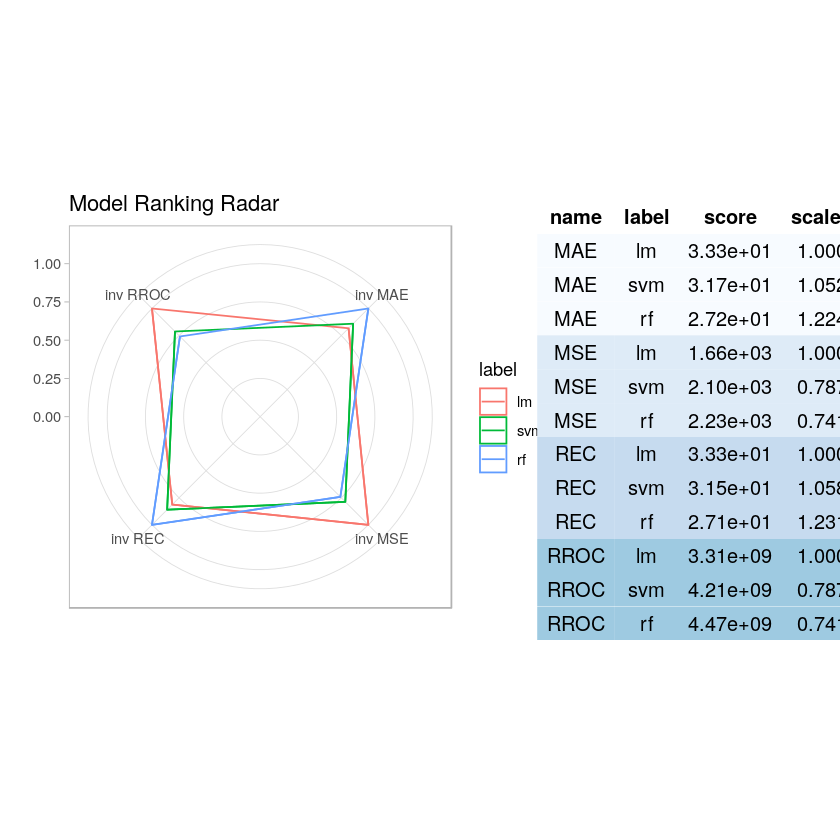

In [220]:
plot(lm_mp, svm_mp, rf_mp, table = TRUE)

## Plotting residuals

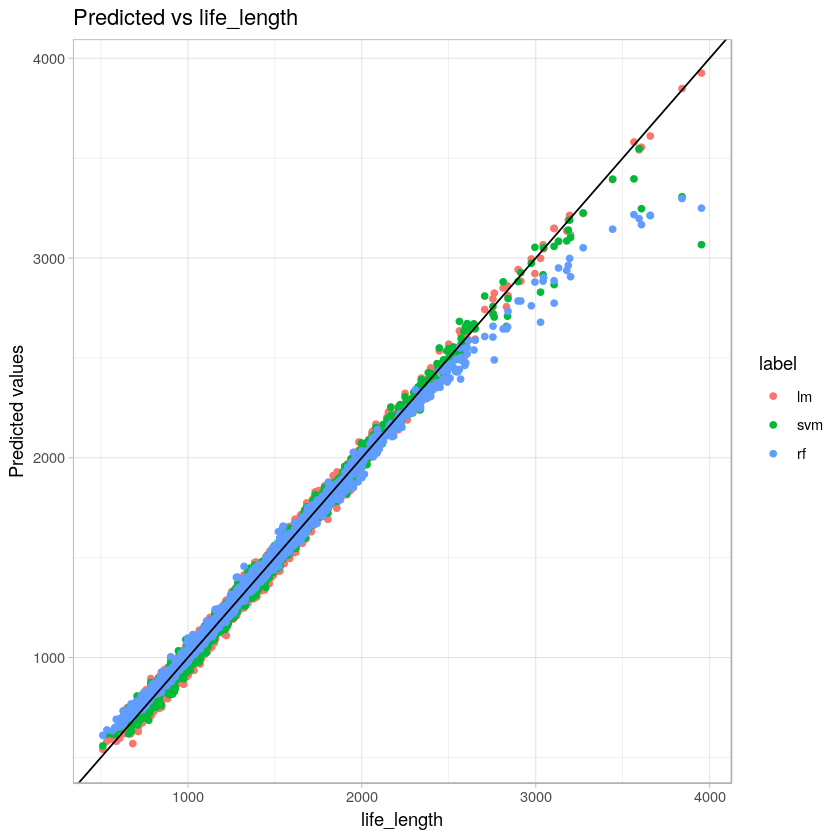

In [221]:
lm_mr_m2 <- modelResiduals(lm_audit, variable = "life_length")
svm_mr_m2 <- modelResiduals(svm_audit, variable = "life_length")
rf_mr_m2 <- modelResiduals(rf_audit, variable = "life_length")

plot(lm_mr_m2, svm_mr_m2, rf_mr_m2, type = "Prediction")

## Residual Density

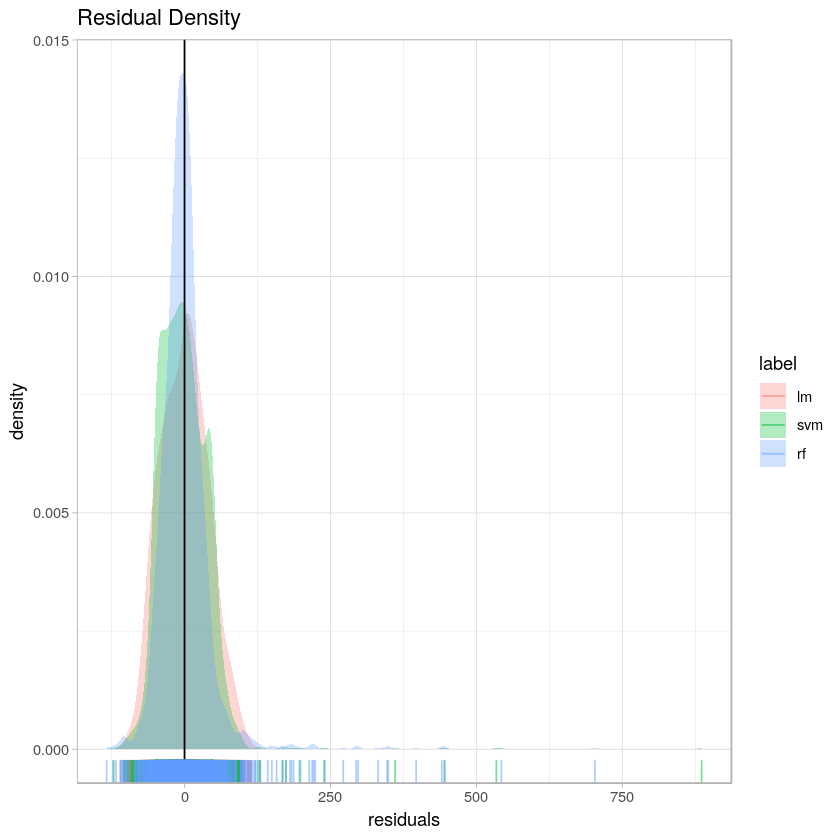

In [222]:
plotResidualDensity(lm_audit, svm_audit, rf_audit)

## Residuals vs variables

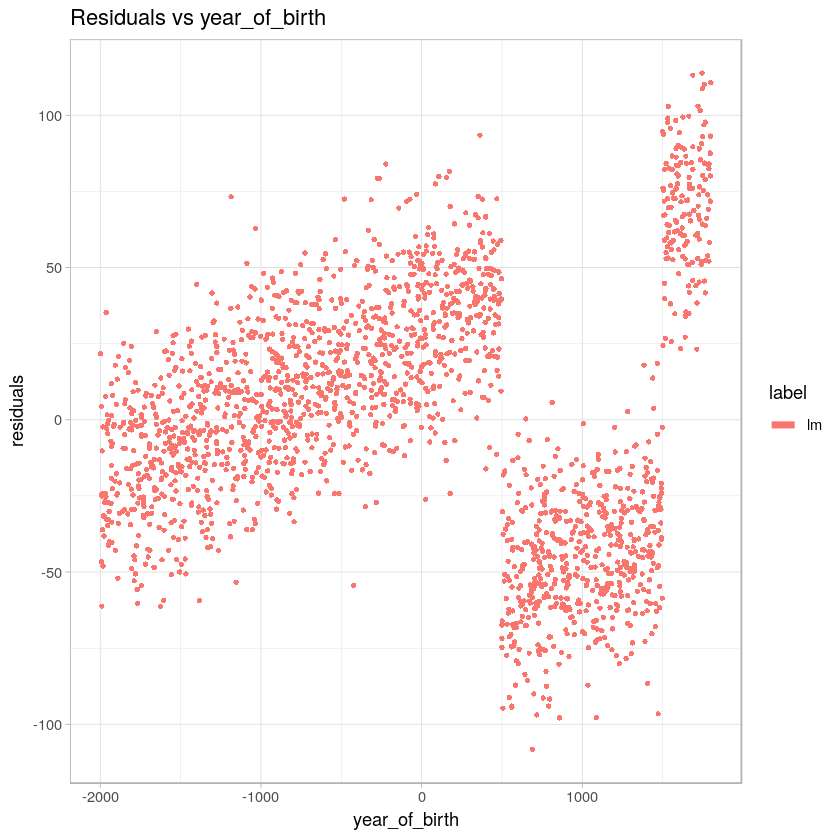

In [223]:
# plotResidual(lm_audit, variable = 'height')
# plotResidual(lm_audit, variable = 'colour')
plotResidual(lm_audit, variable = 'year_of_birth')
# plotResidual(lm_audit, variable = 'year_of_discovery')
# plotResidual(lm_audit, variable = 'scars')

In [248]:
dragons$period <- cut(dragons$year_of_birth, c(-2000, 500, 1500, 2000), 
                 labels = c('ancient', 'middle_ages', 'early_modern'), include.lowest = TRUE)
dragons_test$period <- cut(dragons_test$year_of_birth, c(-2000, 500, 1500, 2000), 
                 labels = c('ancient', 'middle_ages', 'early_modern'), include.lowest = TRUE)

head(dragons)
head(dragons_test)

year_of_birth,height,weight,scars,colour,year_of_discovery,number_of_lost_teeth,life_length,period
-1291,59.40365,15.32391,7,red,1700,25,1368.4331,ancient
1589,46.21374,11.80819,5,red,1700,28,1377.0474,early_modern
1528,49.17233,13.34482,6,red,1700,38,1603.9632,early_modern
1645,48.29177,13.27427,5,green,1700,33,1434.4222,early_modern
-8,49.99679,13.08757,1,red,1700,18,985.4905,ancient
915,45.40876,11.48717,2,red,1700,20,969.5682,middle_ages


year_of_birth,height,weight,scars,colour,year_of_discovery,number_of_lost_teeth,life_length,period
-938,39.18619,10.02391,4,black,1800,30,1375.380,ancient
-512,50.94147,13.04473,27,green,1800,10,1908.353,ancient
291,40.87489,10.45302,4,black,1800,24,1243.799,ancient
1633,49.01880,13.37044,16,blue,1800,32,1870.242,early_modern
-1193,59.24269,14.82285,4,red,1800,27,1306.369,ancient
1594,52.16843,13.34594,2,red,1801,26,1193.924,early_modern


## New models

In [225]:
lm_model <- lm(life_length ~ ., data=dragons)
svm_model <- svm(life_length ~ ., data=dragons)
rf_model <- randomForest(life_length ~ ., data=dragons)

In [244]:
# generate report
modelDown(explain(model = 1, data = dragons, y = dragons$life_length, predict_function = true_model), 
          explain(model = lm_model, data = dragons, y = dragons$life_length), 
          explain(model = svm_model, data = dragons, y = dragons$life_length),
          explain(model = rf_model, data = dragons, y = dragons$life_length))

[1] "Generating model_performance..."
[1] "Generating variable_importance..."
[1] "Generating variable_response..."


Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


In [227]:
lm_audit <- audit(lm_model, label = "lm", data = dragons, y = dragons$life_length)
svm_audit <- audit(svm_model, label = "svm", data = dragons, y = dragons$life_length)
rf_audit <- audit(rf_model, label = "rf", data = dragons, y = dragons$life_length)

In [228]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
svm_mp <- modelPerformance(svm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
rf_mp <- modelPerformance(rf_audit, scores = c("MAE", "MSE", "REC", "RROC"))

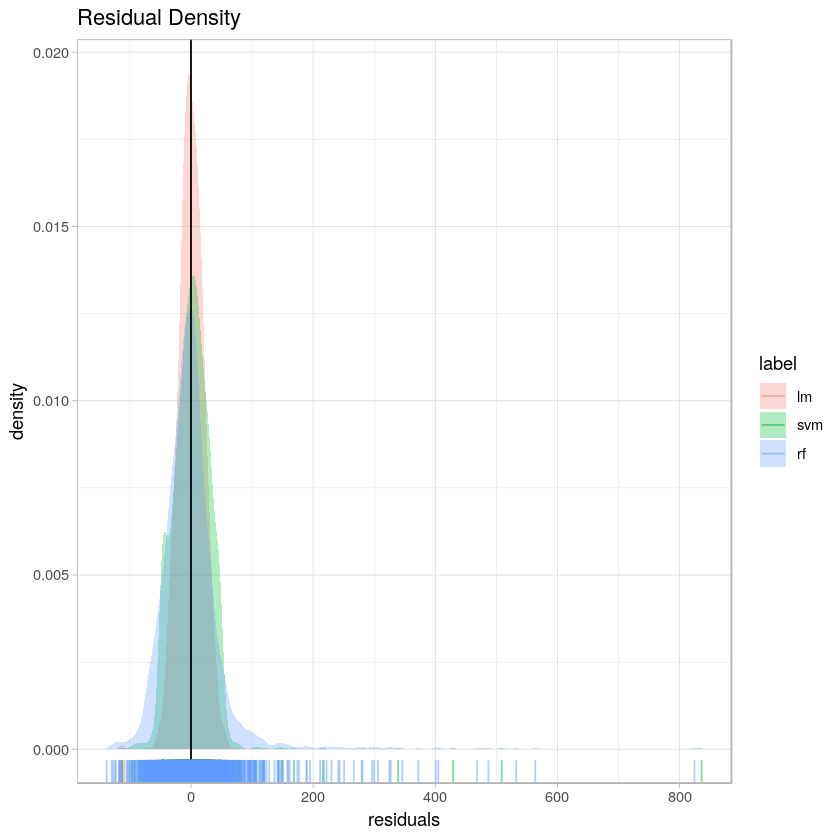

In [229]:
plotResidualDensity(lm_audit, svm_audit, rf_audit)

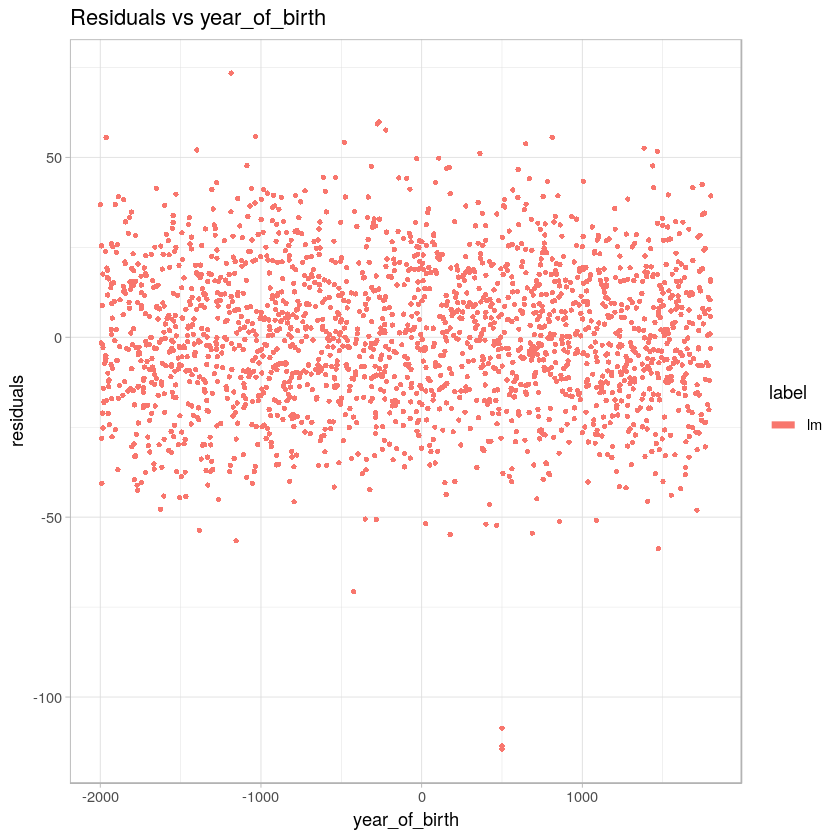

In [230]:
plotResidual(lm_audit, variable = 'year_of_birth')

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


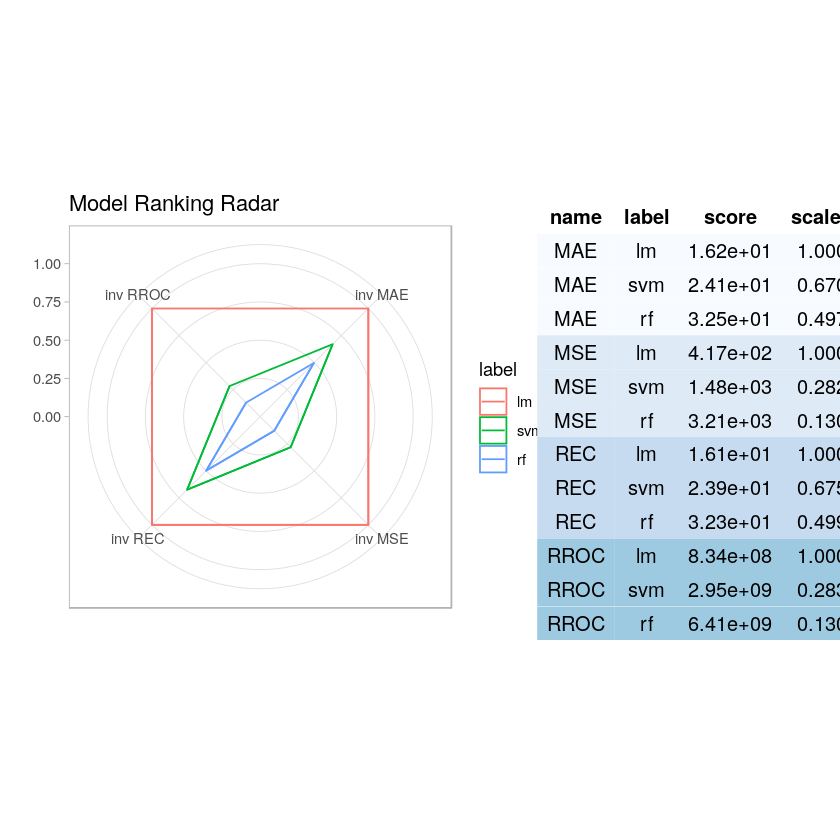

In [231]:
plot(lm_mp, svm_mp, rf_mp, table = TRUE)

# MODELS ON TEST (with concept drift)

In [237]:
lm_model <- lm(life_length ~ ., data=dragons)

library("e1071")
svm_model <- svm(life_length ~ ., data=dragons)
rf_model <- randomForest(life_length ~ ., data=dragons)

In [249]:
lm_audit <- audit(lm_model, label = "lm", data = dragons_test, y = dragons_test$life_length)
svm_audit <- audit(svm_model, label = "svm", data = dragons_test, y = dragons_test$life_length)
rf_audit <- audit(rf_model, label = "rf", data = dragons_test, y = dragons_test$life_length)

In [250]:
# generate report
modelDown(explain(model = 1, data = dragons_test, y = dragons_test$life_length, predict_function = true_model), 
          explain(model = lm_model, data = dragons_test, y = dragons_test$life_length), 
          explain(model = svm_model, data = dragons_test, y = dragons_test$life_length),
          explain(model = rf_model, data = dragons_test, y = dragons_test$life_length))

[1] "Generating model_performance..."
[1] "Generating variable_importance..."
[1] "Generating variable_response..."


Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the c

[1] "Generating prediction_breakdown..."


## Model performance

In [251]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
svm_mp <- modelPerformance(svm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
rf_mp <- modelPerformance(rf_audit, scores = c("MAE", "MSE", "REC", "RROC"))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


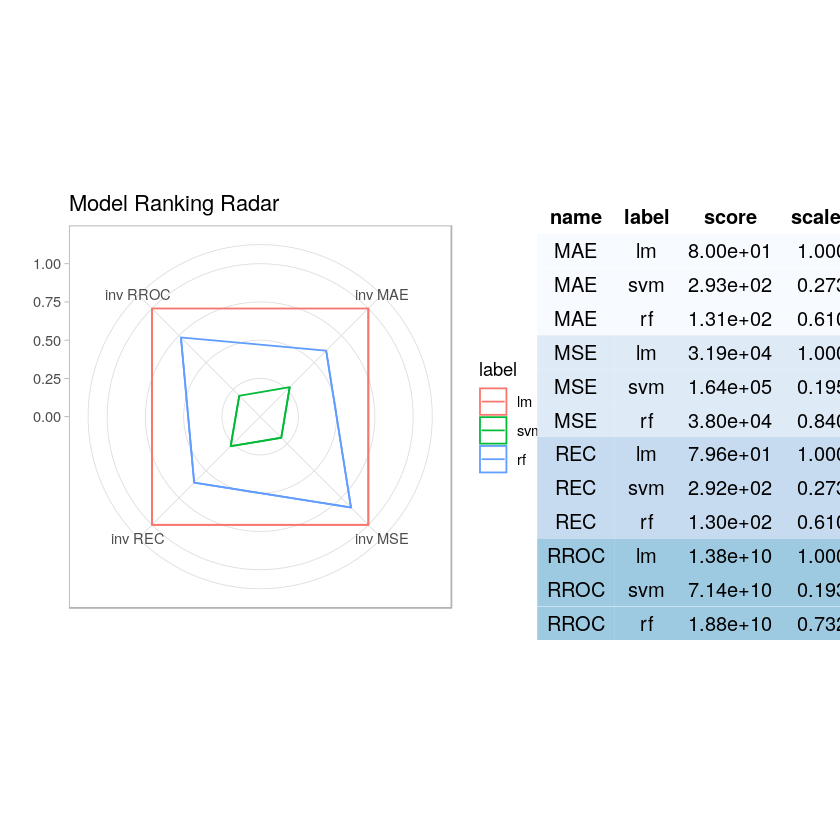

In [252]:
plot(lm_mp, svm_mp, rf_mp, table = TRUE)

## Plotting residuals

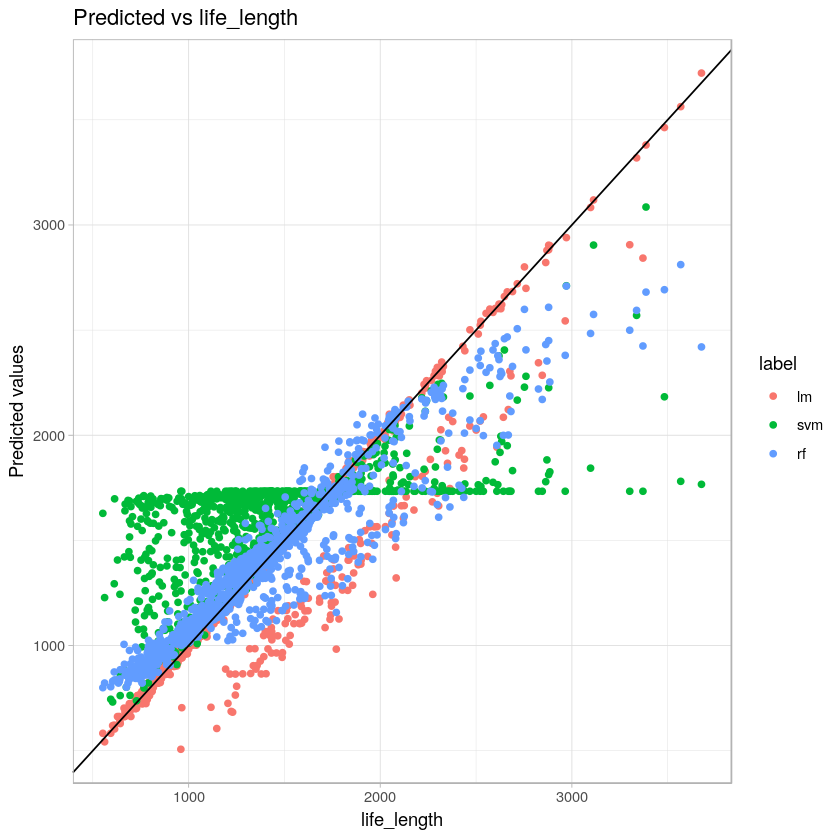

In [253]:
lm_mr_m2 <- modelResiduals(lm_audit, variable = "life_length")
svm_mr_m2 <- modelResiduals(svm_audit, variable = "life_length")
rf_mr_m2 <- modelResiduals(rf_audit, variable = "life_length")


plot(lm_mr_m2, svm_mr_m2, rf_mr_m2, type = "Prediction")

## Residual Density

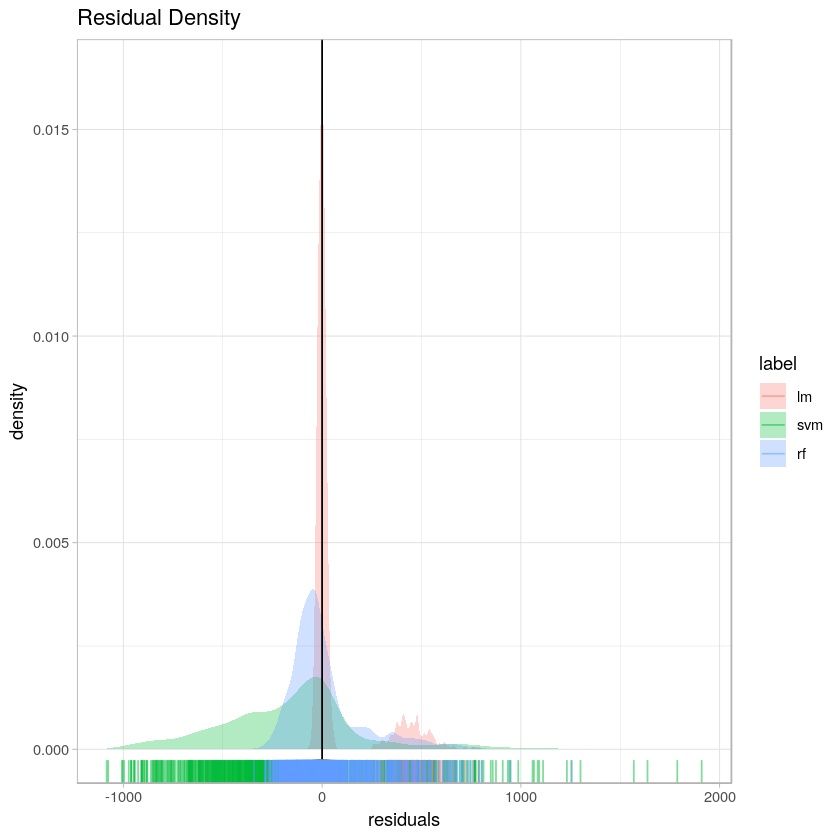

In [254]:
plotResidualDensity(lm_audit, svm_audit, rf_audit)

## Residuals vs variables

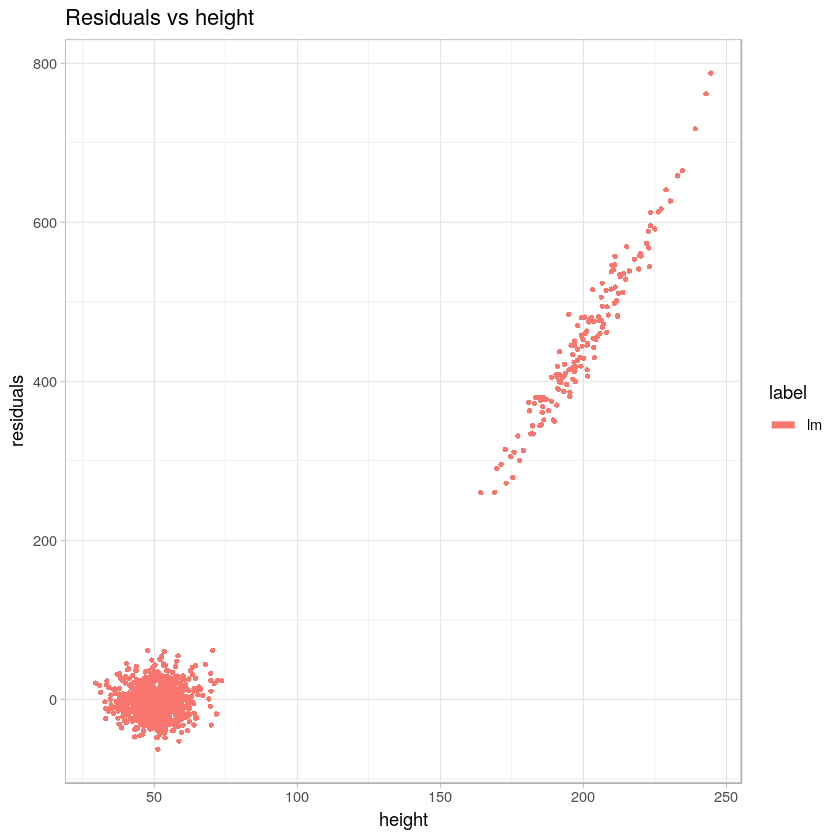

In [255]:
plotResidual(lm_audit, variable = 'height')
# plotResidual(lm_audit, variable = 'colour')
# plotResidual(lm_audit, variable = 'year_of_birth')
# plotResidual(lm_audit, variable = 'year_of_discovery')
# plotResidual(lm_audit, variable = 'scars')

In [256]:
dragons$height_squared <- dragons$height^2
dragons_test$height_squared <- dragons_test$height^2

## New models

In [257]:
lm_model <- lm(life_length ~ ., data=dragons)
svm_model <- svm(life_length ~ ., data=dragons)
rf_model <- randomForest(life_length ~ ., data=dragons)

In [258]:
# generate report
modelDown(explain(model = 1, data = dragons_test, y = dragons_test$life_length, predict_function = true_model), 
          explain(model = lm_model, data = dragons_test, y = dragons_test$life_length), 
          explain(model = svm_model, data = dragons_test, y = dragons_test$life_length),
          explain(model = rf_model, data = dragons_test, y = dragons_test$life_length))

[1] "Generating model_performance..."
[1] "Generating variable_importance..."
[1] "Generating variable_response..."


Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the c

[1] "Generating prediction_breakdown..."


In [259]:
lm_audit <- audit(lm_model, label = "lm", data = dragons_test, y = dragons_test$life_length)
svm_audit <- audit(svm_model, label = "svm", data = dragons_test, y = dragons_test$life_length)
rf_audit <- audit(rf_model, label = "rf", data = dragons_test, y = dragons_test$life_length)

In [260]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
svm_mp <- modelPerformance(svm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
rf_mp <- modelPerformance(rf_audit, scores = c("MAE", "MSE", "REC", "RROC"))

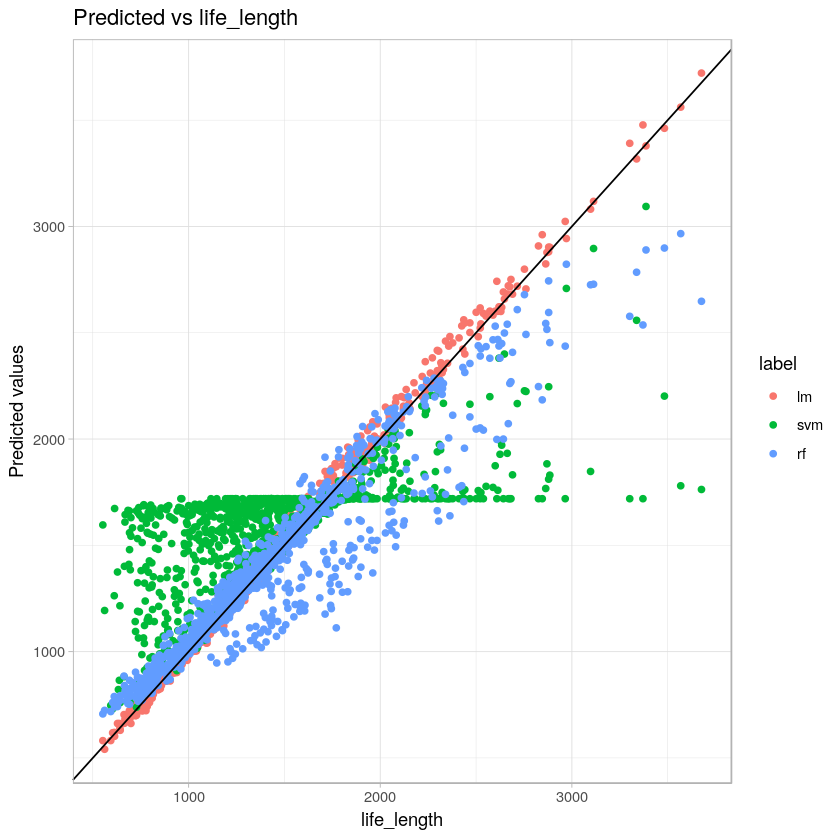

In [261]:
lm_mr_m2 <- modelResiduals(lm_audit, variable = "life_length")
svm_mr_m2 <- modelResiduals(svm_audit, variable = "life_length")
rf_mr_m2 <- modelResiduals(rf_audit, variable = "life_length")


plot(lm_mr_m2, svm_mr_m2, rf_mr_m2, type = "Prediction")

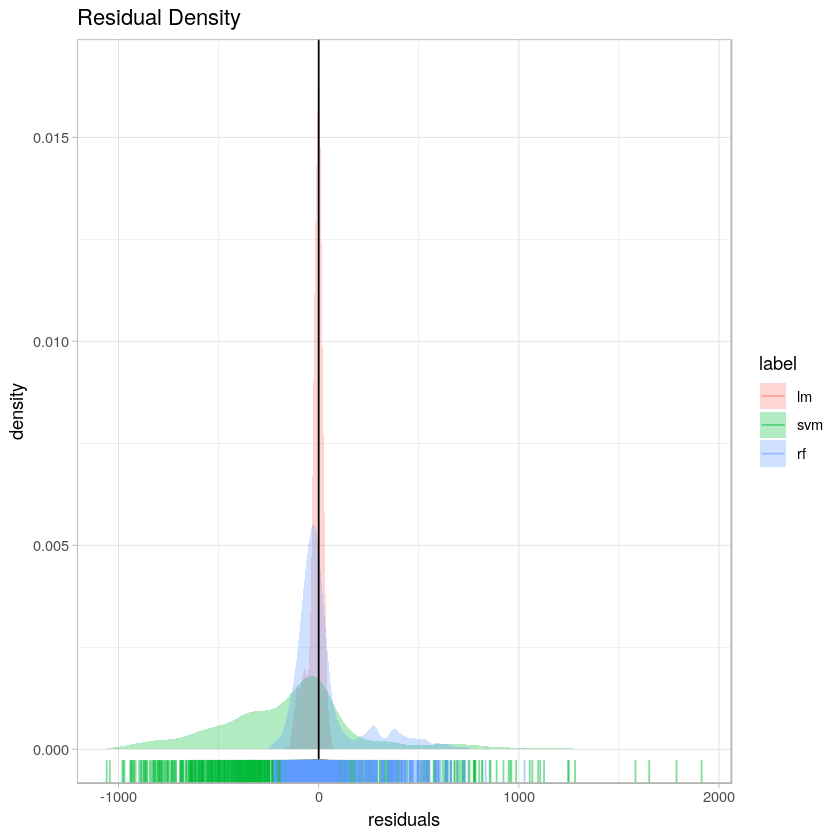

In [262]:
plotResidualDensity(lm_audit, svm_audit, rf_audit)

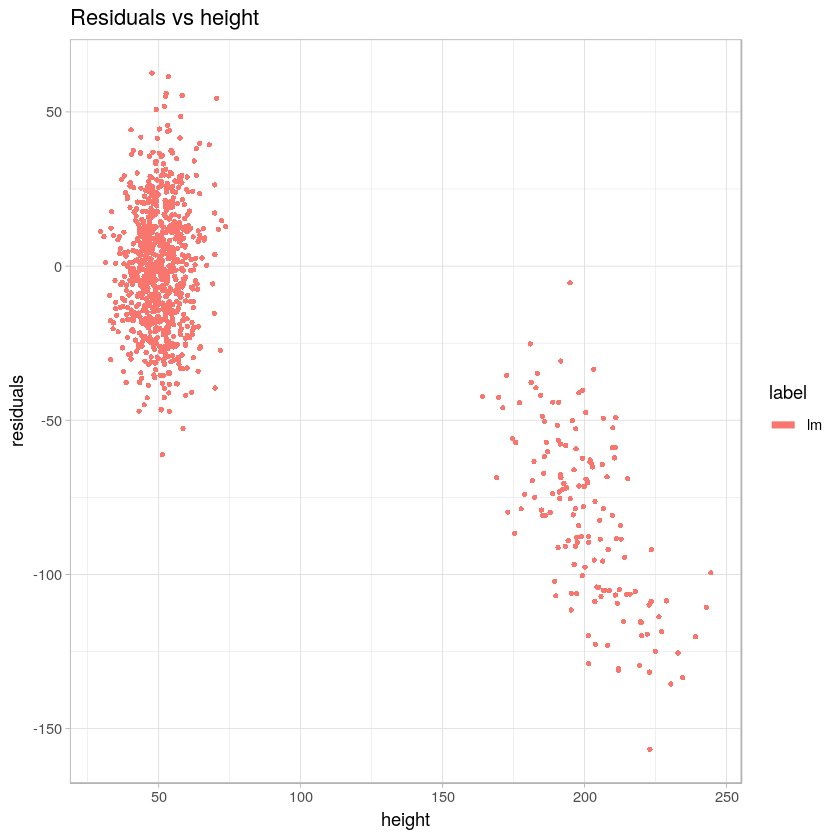

In [263]:
plotResidual(lm_audit, variable = 'height')

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


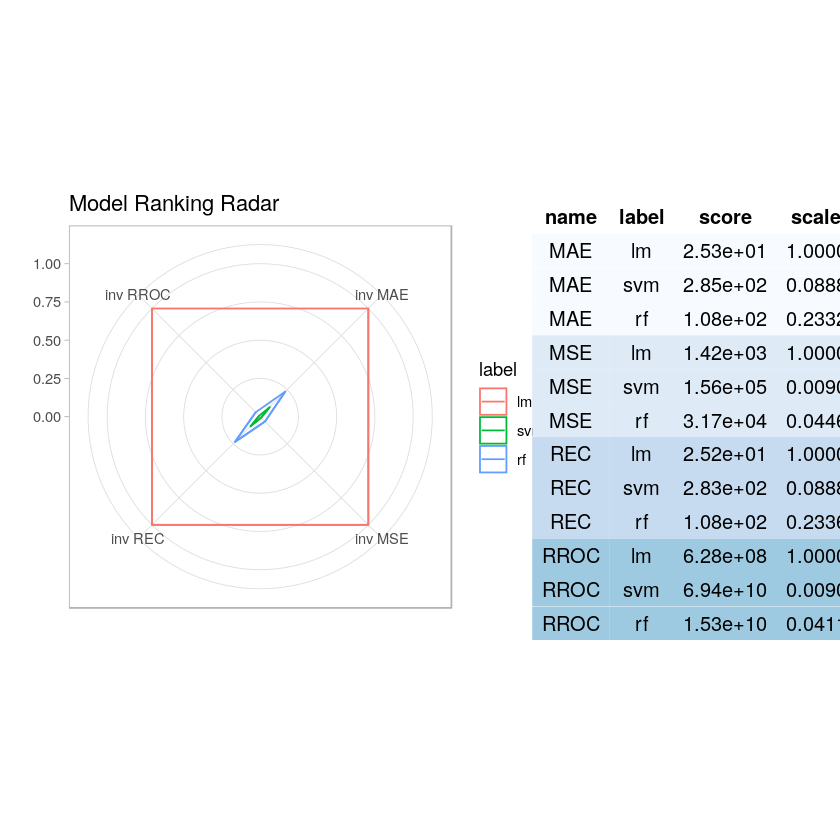

In [264]:
plot(lm_mp, svm_mp, rf_mp, table = TRUE)

# Models on train and test

In [265]:
dragons_whole = rbind(dragons, dragons_test)

In [266]:
lm_model <- lm(life_length ~ ., data=dragons_whole)
svm_model <- svm(life_length ~ ., data=dragons_whole)
rf_model <- randomForest(life_length ~ ., data=dragons_whole)

In [267]:
# generate report
modelDown(explain(model = 1, data = dragons_test, y = dragons_test$life_length, predict_function = true_model), 
          explain(model = lm_model, data = dragons_test, y = dragons_test$life_length), 
          explain(model = svm_model, data = dragons_test, y = dragons_test$life_length),
          explain(model = rf_model, data = dragons_test, y = dragons_test$life_length))

[1] "Generating model_performance..."
[1] "Generating variable_importance..."
[1] "Generating variable_response..."


Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the c

[1] "Generating prediction_breakdown..."


In [268]:
lm_audit <- audit(lm_model, label = "lm", data = dragons_whole, y = dragons_whole$life_length)
svm_audit <- audit(svm_model, label = "svm", data = dragons_whole, y = dragons_whole$life_length)
rf_audit <- audit(rf_model, label = "rf", data = dragons_whole, y = dragons_whole$life_length)

In [269]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
svm_mp <- modelPerformance(svm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
rf_mp <- modelPerformance(rf_audit, scores = c("MAE", "MSE", "REC", "RROC"))

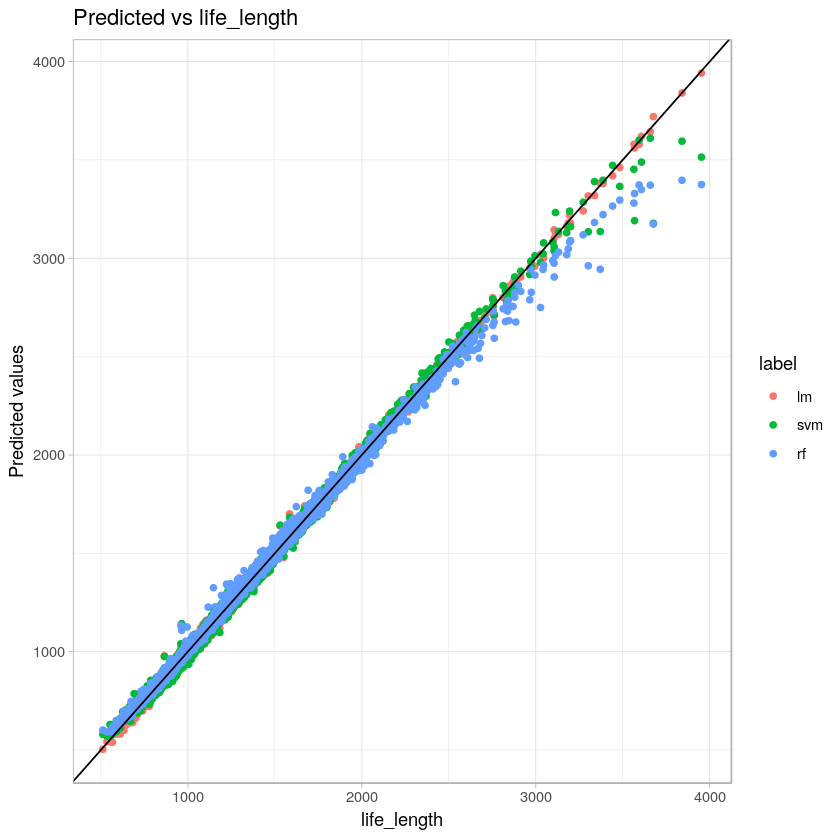

In [270]:
lm_mr_m2 <- modelResiduals(lm_audit, variable = "life_length")
svm_mr_m2 <- modelResiduals(svm_audit, variable = "life_length")
rf_mr_m2 <- modelResiduals(rf_audit, variable = "life_length")


plot(lm_mr_m2, svm_mr_m2, rf_mr_m2, type = "Prediction")

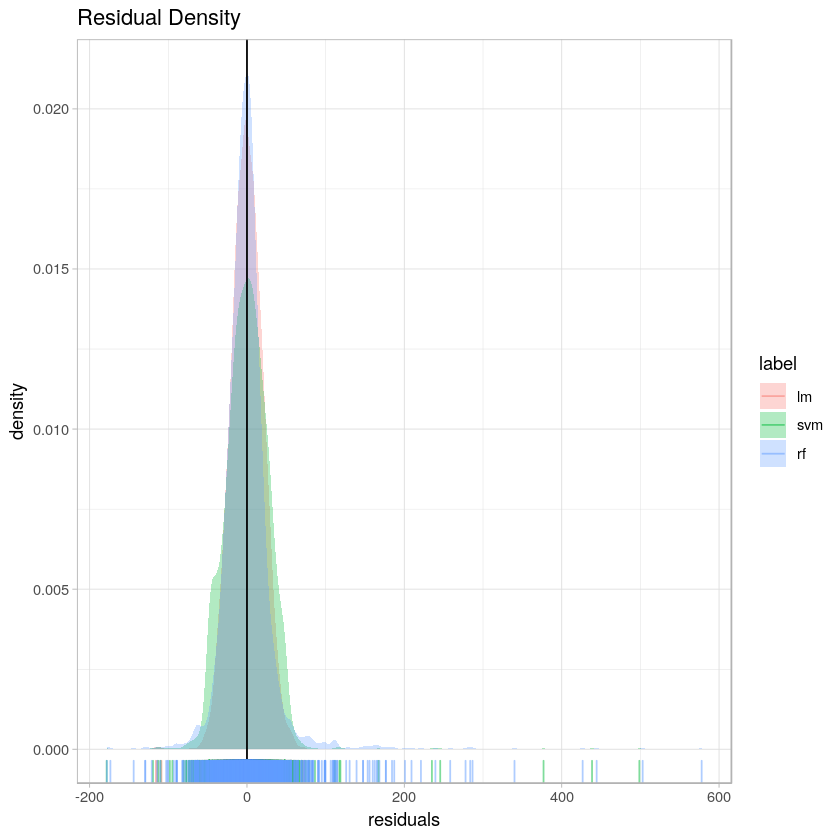

In [271]:
plotResidualDensity(lm_audit, svm_audit, rf_audit)

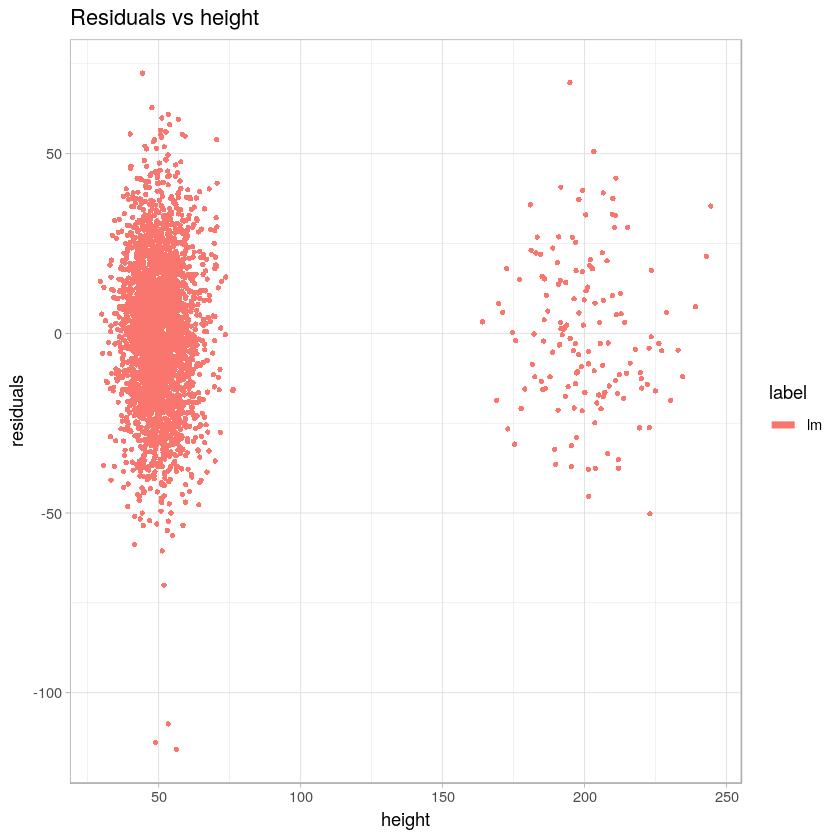

In [272]:
plotResidual(lm_audit, variable = 'height')

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


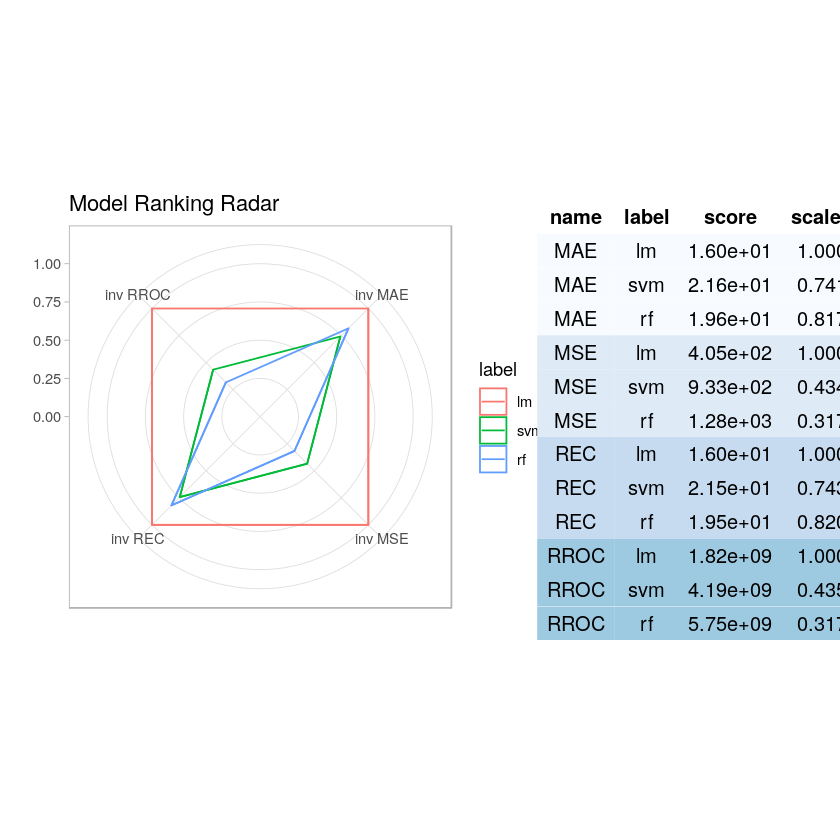

In [274]:
plot(lm_mp, svm_mp, rf_mp, table = TRUE)